# Spam Detection

In [35]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv("./spam.csv", encoding="cp1252")

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
new_df = df[["v1", "v2"]]
new_df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Checking data set for balance

In [43]:
(df["v1"] == "ham").shape, (df["v1"] == "spam").shape

((5572,), (5572,))

### Conclusion:
 * The dataset is balanced (we can use the accuracy to validate the modal)
 * We want to avoid false positive (so we should prioritize precision)

 * Precision: When I predict positive, how often am I right?

 * Missing a positive (false negative) is more harmful than a false alarm. This is not important so we should not prioritize recall (Sensitivity).

 * The F1 score is the harmonic mean of precision and recall. (Not as important here)(Accuracy can be misleading when classes are imbalanced so we use f1 score then)

# Preprocessing convert string to numbers

In [8]:
cv = CountVectorizer(max_features=1000)

In [11]:
sparse_messages =cv.fit_transform(df["v2"])

In [21]:
x = torch.tensor(sparse_messages.todense(),dtype=torch.float32)
y = torch.tensor((df["v1"] == "spam").astype(int), dtype=torch.float32).reshape((-1, 1))

In [22]:
x.shape, y.shape

(torch.Size([5572, 1000]), torch.Size([5572, 1]))

# Split Train and Test

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

In [37]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([4457, 1000]),
 torch.Size([1115, 1000]),
 torch.Size([4457, 1]),
 torch.Size([1115, 1]))

# Creating the Logistic model

NOTE:
 * BCEWithLogitsLoss has sigmoid function build in
 * But for prediction we need to add our own sigmoid function

0.3946962058544159
0.32238444685935974
0.2780340909957886
0.24696624279022217
0.22398942708969116
0.2062820941209793
0.19218015670776367
0.18065106868743896
0.17102396488189697
0.16284456849098206
0.15579426288604736
0.1496429294347763
0.14421989023685455
0.13939572870731354
0.13507062196731567
0.13116613030433655
0.1276196837425232
0.12438078969717026
0.12140822410583496
0.11866790056228638
0.1161314994096756
0.11377517133951187
0.11157871782779694
0.1095249354839325


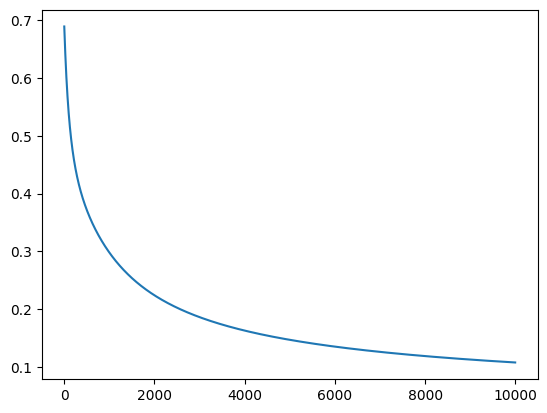

In [40]:
model = torch.nn.Linear(1000, 1)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

losses = []

for epoc in range(1, 10000):
  optimizer.zero_grad()
  output = model(X_train)
  loss = loss_fn(output, y_train)
  losses.append(loss.item())
  loss.backward()
  optimizer.step()

  if epoc % 400 == 0:
    print(loss.item())

plt.plot(losses)

# Predicting Values

In [64]:
model.eval()

y_pred = None

with torch.no_grad():
  y_pred = torch.sigmoid(model(X_test))
  print(y_pred.min())
  print(y_pred.max())

tensor(2.0890e-07)
tensor(0.9992)


# Evaluating the Model

* Accuracy
* Recall
* Precision
* Specificity
* Confusion metrix

In [65]:
y_pred_binary = (y_pred > 0.5).float()

In [66]:
from sklearn.metrics import accuracy_score, precision_score, f1_score

print("Accuracy: ", accuracy_score(y_test, y_pred_binary))
print("Precision: ", precision_score(y_test, y_pred_binary))
print("F1 score: ", f1_score(y_test, y_pred_binary))

Accuracy:  0.9668161434977578
Precision:  0.9747899159663865
F1 score:  0.862453531598513


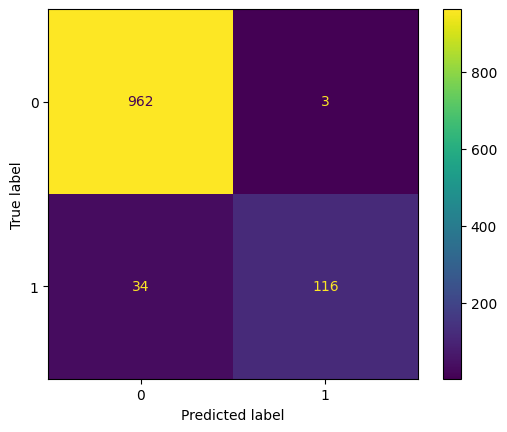

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_binary)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()